In [ ]:
import numpy as np
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive(1)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
import os, cv2
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

In [7]:
DATA_DIR = '/content/drive/MyDrive/archive(1)'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))

metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)


valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [8]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))

class_names = class_dict['name'].tolist()

class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriclture_land', 'grass', 'tree', 'water', 'plain_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [9]:

select_classes = ['urban_land', 'agriclture_land', 'grass', 'tree', 'water', 'plain_land', 'unknown']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriclture_land', 'grass', 'tree', 'water', 'plain_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [10]:

def visualize(**images):
    
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()


def one_hot_encode(label, label_values):
   
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
def reverse_one_hot(image):
  
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [11]:
class LandCoverDataset(torch.utils.data.Dataset):

    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (512, 512))
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask=cv2.resize(mask, (512, 512))
       
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        
        return len(self.image_paths)

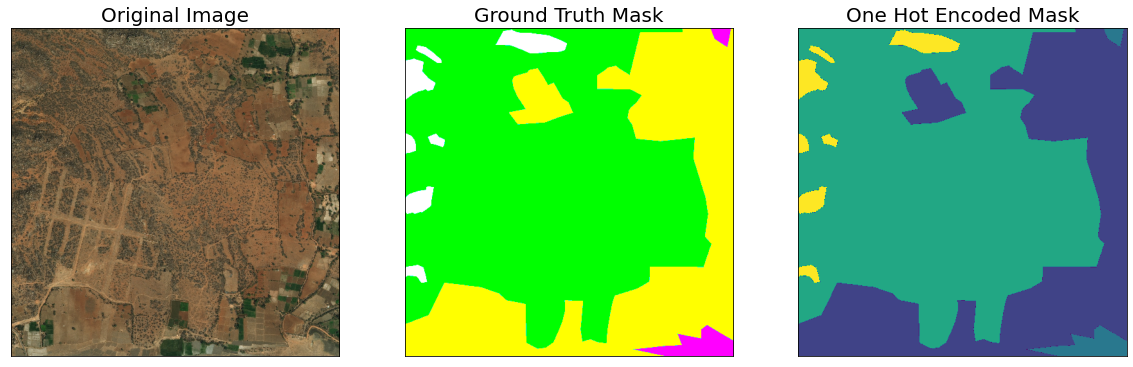

In [12]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [13]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

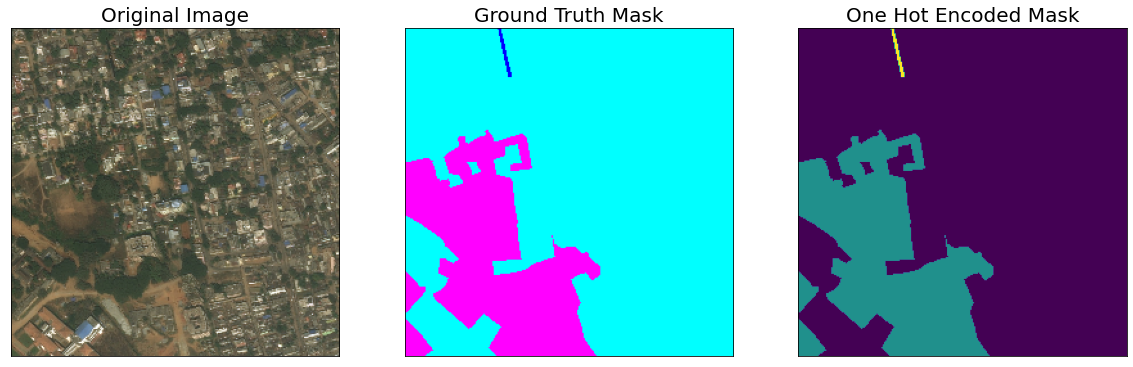

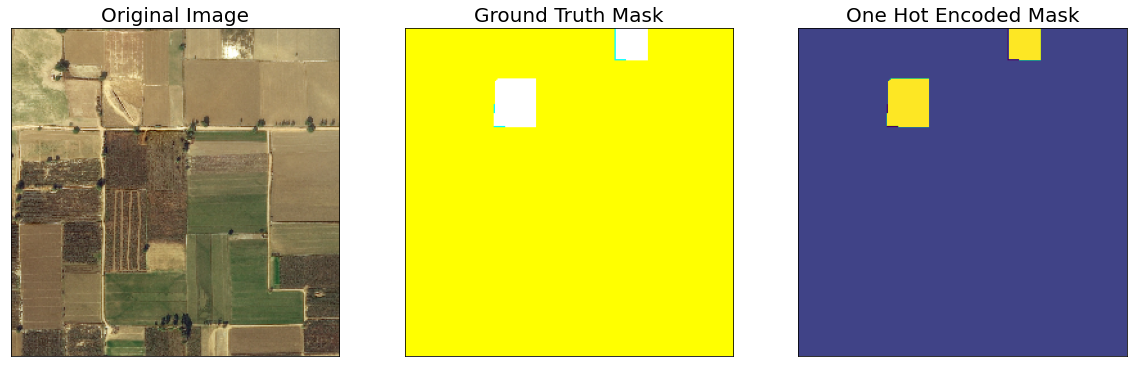

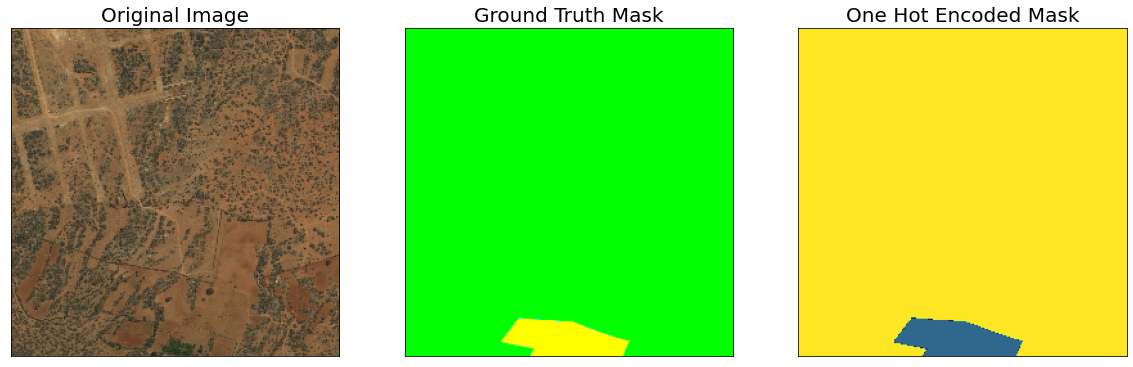

In [14]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [15]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' 


model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [18]:
torch.cuda.is_available()

True

In [19]:
TRAINING = True


EPOCHS = 10


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

if os.path.exists('/content/drive/MyDrive/archive(1)/best_model.pth'):
    model = torch.load('/content/drive/MyDrive/archive(1)/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [21]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 80/80 [00:18<00:00,  4.36it/s, dice_loss - 0.4715, iou_score - 0.606]
Model saved!

Epoch: 1
valid: 100%|██████████| 80/80 [00:18<00:00,  4.39it/s, dice_loss - 0.3018, iou_score - 0.6629]
Model saved!

Epoch: 2
valid: 100%|██████████| 80/80 [00:18<00:00,  4.40it/s, dice_loss - 0.2724, iou_score - 0.6739]
Model saved!

Epoch: 3
valid: 100%|██████████| 80/80 [00:18<00:00,  4.28it/s, dice_loss - 0.2787, iou_score - 0.6545]

Epoch: 4
valid: 100%|██████████| 80/80 [00:18<00:00,  4.22it/s, dice_loss - 0.2404, iou_score - 0.6933]
Model saved!

Epoch: 5
valid: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s, dice_loss - 0.2097, iou_score - 0.7219]
Model saved!

Epoch: 6
valid: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s, dice_loss - 0.2477, iou_score - 0.6765]

Epoch: 7
valid: 100%|██████████| 80/80 [00:18<00:00,  4.36it/s, dice_loss - 0.2351, iou_score - 0.6868]

Epoch: 8
valid: 100%|██████████| 80/80 [00:18<00:00,  4.39it/s, dice_loss - 0.2012, iou_score -

In [22]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')


elif os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


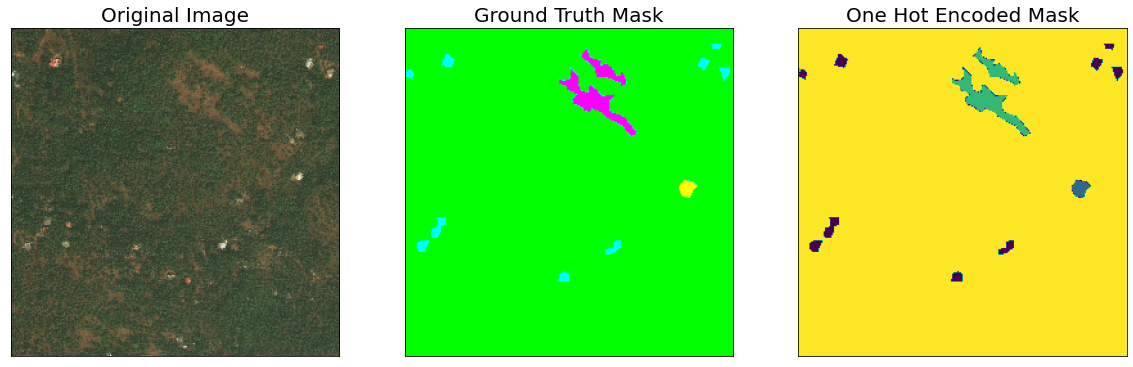

In [23]:
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [24]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [25]:
best_model = model

In [26]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
   
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    
    pred_mask = np.transpose(pred_mask,(1,2,0))
    
    pred_forest_land_heatmap = pred_mask[:,:,select_classes.index('tree')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_forest_land_heatmap = pred_forest_land_heatmap
    )

Output hidden; open in https://colab.research.google.com to view.

In [27]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)                                                                                    

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s, dice_loss - 0.2143, iou_score - 0.7032]
Evaluation on Test Data: 
Mean IoU Score: 0.7032
Mean Dice Loss: 0.2143


In [28]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.630585,0.456753,0.371997,0.334314,0.306248,0.276254,0.261297,0.261841,0.243628,0.238223
iou_score,0.368457,0.538905,0.571262,0.584857,0.607980,0.634813,0.642943,0.637749,0.653894,0.658212


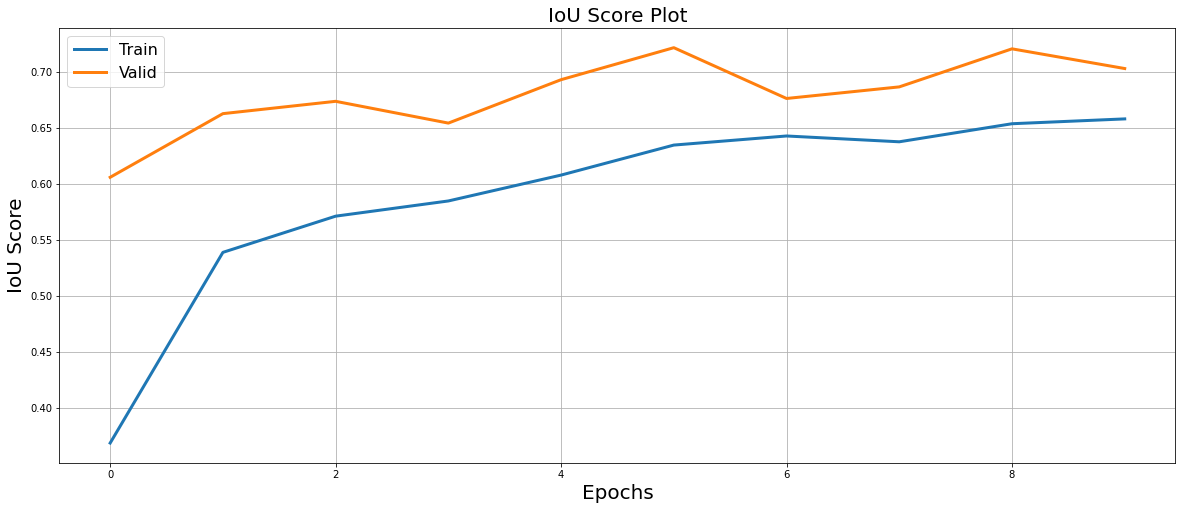

In [29]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

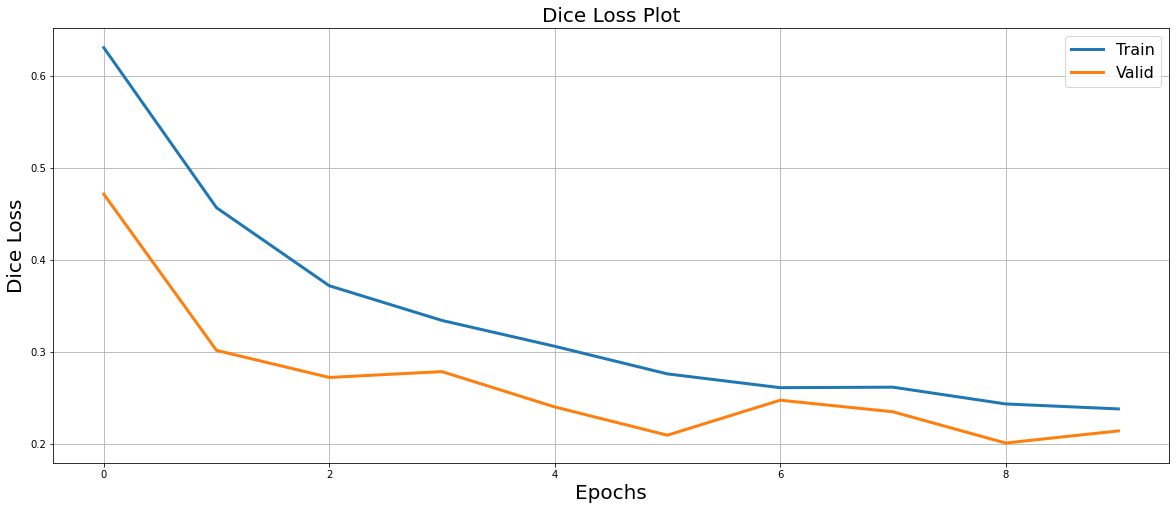

In [30]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()
